# 스프린트 미션 15
이번 미션에서는 포르투갈 은행의 마케팅 데이터를 분석해볼 예정입니다. 이 실습에서는 결정 트리와 앙상블 기법을 사용하여 분류 모델을 구축하고, 마케팅 캠페인의 효율성을 높이는 전략을 도출해 보겠습니다.

### 미션 소개

# 1. 데이터 불러오기

## 1-1. 라이브러리 불러오기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

| 컬럼명               | 설명                                      |
|---------------------|-----------------------------------------|
| age                 | 나이 (숫자)                             |
| job                 | 직업 (범주형)                           |
| marital             | 결혼 여부 (범주형)                     |
| education           | 교육 수준 (범주형)                     |
| default             | 신용 불량 여부 (범주형)                |
| housing             | 주택 대출 여부 (범주형)                |
| loan                | 개인 대출 여부 (범주형)                |
| contact             | 연락 유형 (범주형)                     |
| month               | 마지막 연락 월 (범주형)                |
| day_of_week         | 마지막 연락 요일 (범주형)              |
| duration            | 마지막 연락 지속 시간, 초 단위 (숫자)  |
| campaign            | 캠페인 동안 연락 횟수 (숫자)          |
| pdays               | 이전 캠페인 후 지난 일수 (숫자)       |
| previous            | 이전 캠페인 동안 연락 횟수 (숫자)     |
| poutcome            | 이전 캠페인의 결과 (범주형)            |
| emp.var.rate        | 고용 변동률 (숫자)                     |
| cons.price.idx      | 소비자 물가지수 (숫자)                 |
| cons.conf.idx       | 소비자 신뢰지수 (숫자)                 |
| euribor3m          | 3개월 유리보 금리 (숫자)               |
| nr.employed         | 고용자 수 (숫자)                       |
| y                   | 정기 예금 가입 여부 (이진: yes=1, no=0) |

거시적인 금융관련 지표
- 외부 환경과 관련된 설명들

고객 자체에 대한 설명을 나타내는 지표
- 나이 결혼여부 교육수준 등등

은행에서 진행하는 캠페인에 관련된 정보들
- 은행 캠페인

가설을 세워보고 증명하는 차원에서
따로따로 모델링도 해보고, 주요 핵심 요인이 뭔지

In [ ]:
df = pd.read_csv("bank-additional-full.csv")
display(df.sample(5))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
28899,39,admin.,married,high.school,unknown,yes,no,cellular,apr,fri,...,1,999,1,failure,-1.8,93.075,-47.1,1.405,5099.1,no
26838,46,technician,divorced,professional.course,no,yes,no,cellular,nov,thu,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,no
11529,29,technician,single,university.degree,no,yes,yes,telephone,jun,fri,...,2,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,yes
3657,35,services,married,high.school,unknown,no,no,telephone,may,fri,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,no
16427,40,entrepreneur,married,university.degree,no,no,no,cellular,jul,wed,...,4,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no


# 2. 탐색적 데이터 분석
데이터에 존재하는 각 컬럼들이 어떤 타입인지, 범주형 데이터인 경우 어떤 값들이 존재하는지, 연속형 변수인 경우 변수의 분포가 어떤지 확인한다.

## 2-1. 데이터 기본 정보 확인

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


## 2-2. 범주형 데이터 확인

In [ ]:
print("job 컬럼 고유값 개수 확인")
print(df['job'].value_counts())
print("\nmarital 컬럼 고유값 개수 확인")
print(df['marital'].value_counts())
print("\neducation 컬럼 고유값 개수 확인")
print(df['education'].value_counts())
print("\nhousing 컬럼 고유값 개수 확인")
print(df['housing'].value_counts())

job 컬럼 고유값 개수 확인
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

marital 컬럼 고유값 개수 확인
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

education 컬럼 고유값 개수 확인
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

housing 컬럼 고유값 개수 확인
yes        21576
no         18622
unknown      990
Name: housing, dtype: int64


In [ ]:
print("\nloan 컬럼 고유값 개수 확인")
print(df['loan'].value_counts())
print("\ncontact 컬럼 고유값 개수 확인")
print(df['contact'].value_counts())
print("\nmonth 컬럼 고유값 개수 확인")
print(df['month'].value_counts())
print("\nday_of_week 컬럼 고유값 개수 확인")
print(df['day_of_week'].value_counts())
print("\npoutcome 컬럼 고유값 개수 확인")
print(df['poutcome'].value_counts())
print("\ny 컬럼 고유값 개수 확인")
print(df['y'].value_counts())


loan 컬럼 고유값 개수 확인
no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

contact 컬럼 고유값 개수 확인
cellular     26144
telephone    15044
Name: contact, dtype: int64

month 컬럼 고유값 개수 확인
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64

day_of_week 컬럼 고유값 개수 확인
thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64

poutcome 컬럼 고유값 개수 확인
nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

y 컬럼 고유값 개수 확인
no     36548
yes     4640
Name: y, dtype: int64


### 컬럼별 고유값 확인 결과
#### 정기예금 가입자 비교
- 총 41,188명의 고객 중에서 36,548명이 정기예금을 가입하지 않음
- 총 41,188명의 고객 중에서 4,640명이 정기예금을 가입하였음


## 2-3. 범주형 데이터 시각화

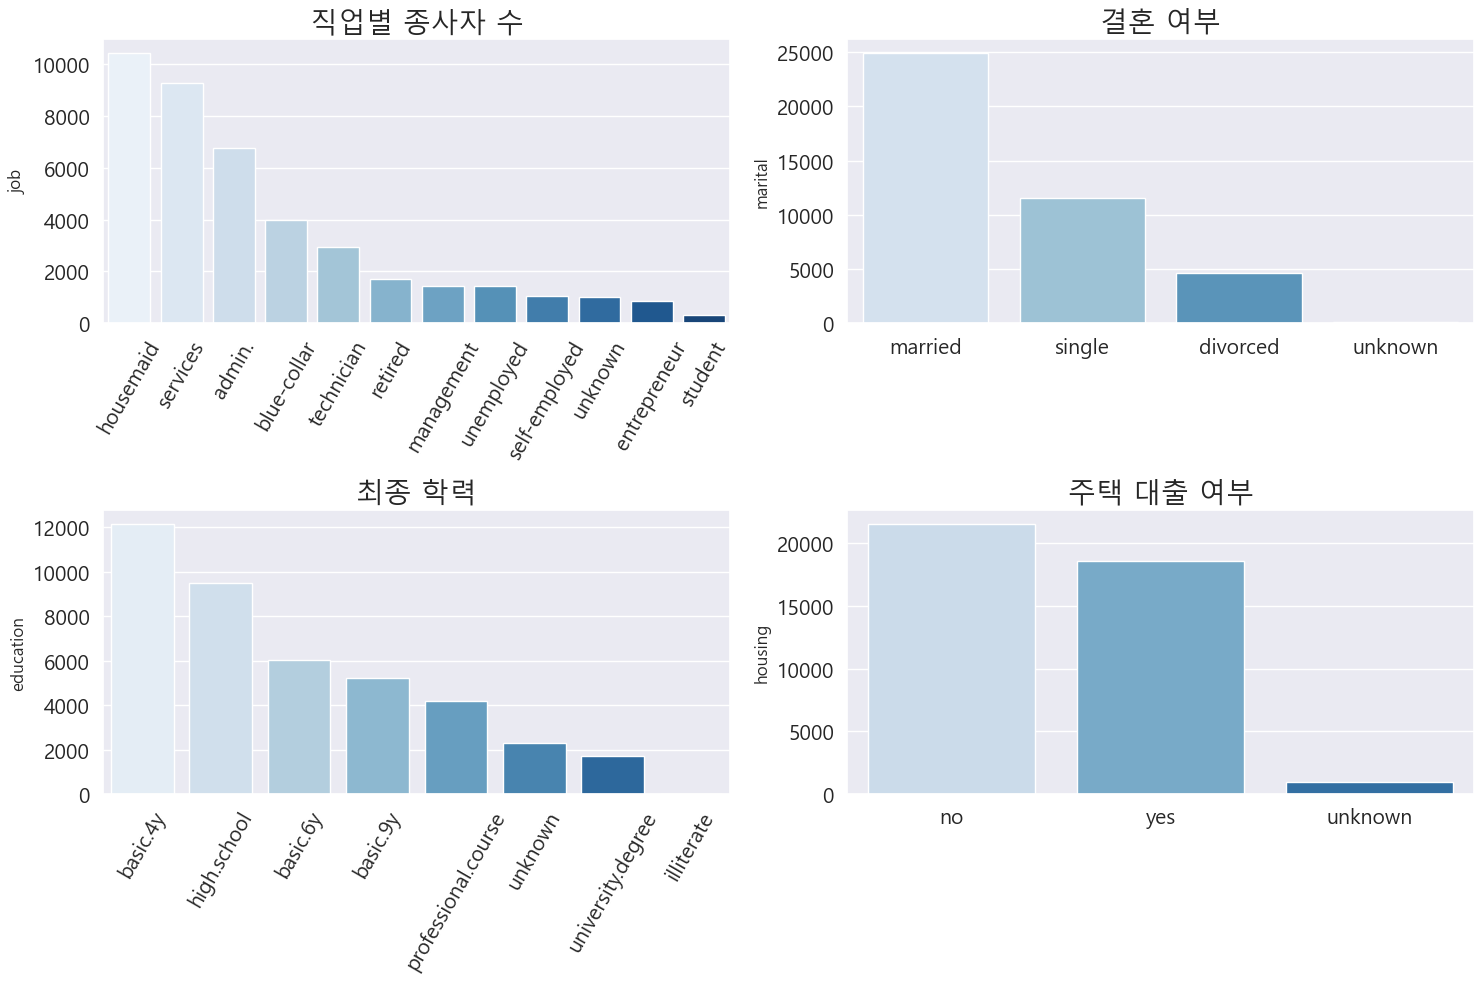

In [ ]:
# 서브플롯 생성하기 (2행, 2열 플롯)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# job 컬럼 막대그래프 시각화
sns.barplot(x=df['job'].unique(), y=df['job'].value_counts(), ax=ax[0, 0], palette='Blues')
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=60, fontsize=15)
# ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), fontsize=15)
ax[0, 0].set_yticklabels(ax[0, 0].get_yticklabels(), fontsize=15)
ax[0, 0].set_title('직업별 종사자 수', fontsize=20)

# marital 컬럼 막대그래프 시각화
sns.barplot(x=df['marital'].unique(), y=df['marital'].value_counts(), ax=ax[0, 1], palette='Blues')
ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), fontsize=15)
ax[0, 1].set_yticklabels(ax[0, 1].get_yticklabels(), fontsize=15)
ax[0, 1].set_title('결혼 여부', fontsize=20)

# education 컬럼 막대그래프 시각화
sns.barplot(x=df['education'].unique(), y=df['education'].value_counts(), ax=ax[1, 0], palette='Blues')
ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), rotation=60)
ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), fontsize=15)
ax[1, 0].set_yticklabels(ax[1, 0].get_yticklabels(), fontsize=15)
ax[1, 0].set_title('최종 학력', fontsize=20)

# housing 컬럼 막대그래프 시각화
sns.barplot(x=df['housing'].unique(), y=df['housing'].value_counts(), ax=ax[1, 1], palette='Blues')
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), fontsize=15)
ax[1, 1].set_yticklabels(ax[1, 1].get_yticklabels(), fontsize=15)
ax[1, 1].set_title('주택 대출 여부', fontsize=20)

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.tight_layout()
plt.show()

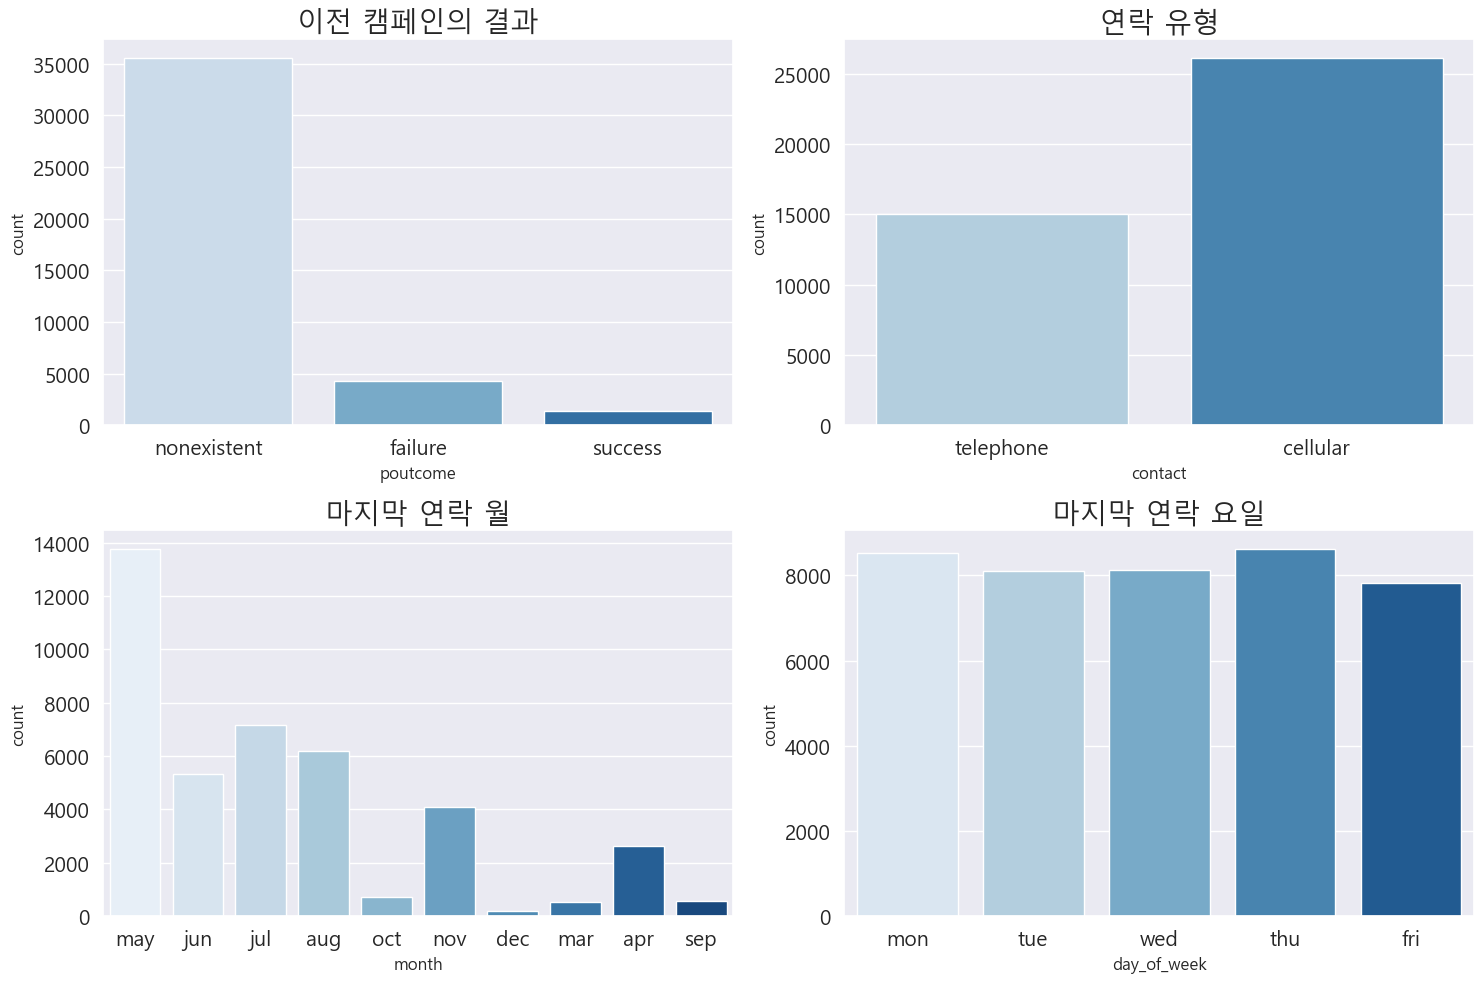

In [ ]:
# 서브플롯 생성하기 (2행, 2열 플롯)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# poutcome 컬럼 막대그래프 시각화
sns.countplot(x=df['poutcome'], ax=ax[0, 0], palette='Blues')
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), fontsize=15)
ax[0, 0].set_yticklabels(ax[0, 0].get_yticklabels(), fontsize=15)
ax[0, 0].set_title('이전 캠페인의 결과', fontsize=20)

# contact 컬럼 막대그래프 시각화
sns.countplot(x=df['contact'], ax=ax[0, 1], palette='Blues')
ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), fontsize=15)
ax[0, 1].set_yticklabels(ax[0, 1].get_yticklabels(), fontsize=15)
ax[0, 1].set_title('연락 유형', fontsize=20)

# month 컬럼 막대그래프 시각화
sns.countplot(x=df['month'], ax=ax[1, 0], palette='Blues')
ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), fontsize=15)
ax[1, 0].set_yticklabels(ax[1, 0].get_yticklabels(), fontsize=15)
ax[1, 0].set_title('마지막 연락 월', fontsize=20)

# day_of_week 컬럼 막대그래프 시각화
sns.countplot(x=df['day_of_week'], ax=ax[1, 1], palette='Blues')
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), fontsize=15)
ax[1, 1].set_yticklabels(ax[1, 1].get_yticklabels(), fontsize=15)
ax[1, 1].set_title('마지막 연락 요일', fontsize=20)

plt.tight_layout()
plt.show()

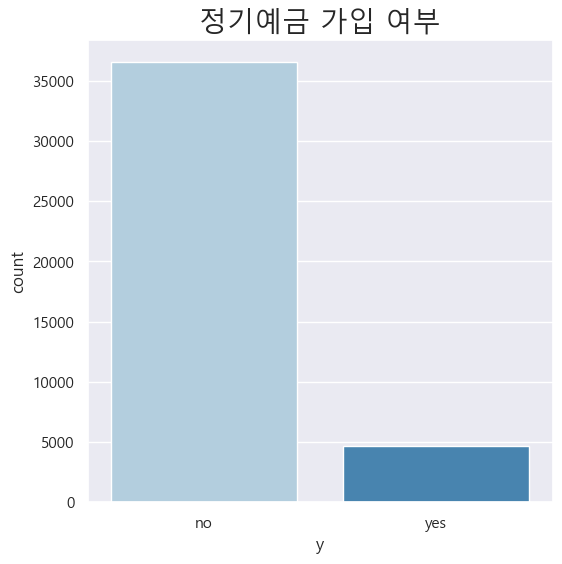

In [ ]:
# 정기예금 가입 여부(y)컬럼 막대그래프 시각화
ax = sns.countplot(x=df['y'], palette='Blues')
# ax.set_xticklabels(ax[1].get_xticklabels(), fontsize=15)
# ax.set_yticklabels(ax[1].get_yticklabels(), fontsize=15)
plt.title('정기예금 가입 여부', fontsize=20)

plt.show()


### 범주형 데이터 시각화 결과 (1)
데이터의 정보를 확인할 수 있는 info 메소드를 통해서는 null값이 존재하지 않는다고 확인되었으나,
<br>범주형 데이터의 고유값 확인과 시각화를 통해서 null값이 **unknown** 이라는 데이터로 변경되어 있음을 확인

-----------

### 범주형 데이터 시각화 결과 (2)
정기예금 가입 여부를 나타내는 **y컬럼을 종속변수**로 설정

-------------

### 범주형 데이터 시각화 결과 (3)
데이터 안에 존재하는 데이터 타입이 object 형태이므로 라벨 인코딩 또는 원 핫 인코딩 등의 범주형 데이터 인코딩 방법을 통해서 범주형 데이터를 전처리 진행

## 2-4. 수치형 데이터 확인

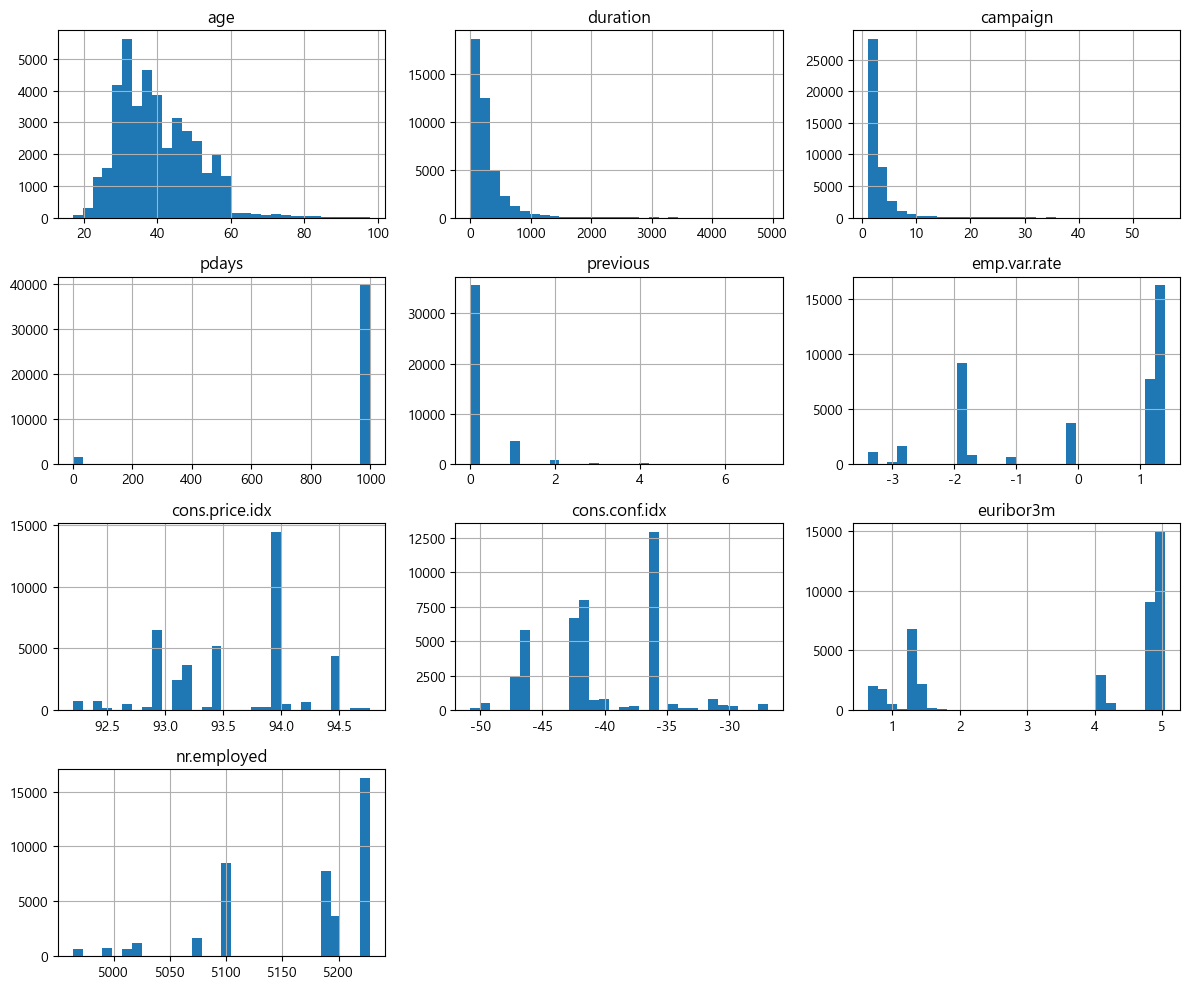

In [ ]:
# 수치형 데이터 컬럼 리스트
num_col = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']

num_df = df[num_col]

# 히스토그램 그리기
num_df.hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.show()

## 2-5. 수치형 변수와 정기예금 가입여부 상관관계 확인

### 1) 상관관계 시각화

In [ ]:
# 수치형 변수와 y를 별도로 저장
num_col_y = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']

# 상관관계 뿐석을 진행할 컬럼만 별도로 df_corr 데이터프레임에 저장
df_corr = df[num_col_y]

# y값을 0과 1로 변환
df_corr['y'] = df_corr['y'].map({'no':0, 'yes':1})

df_corr.sample(5)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
7682,23,390,2,999,0,1.1,93.994,-36.4,4.864,5191.0,0
30938,33,118,2,999,1,-1.8,92.893,-46.2,1.344,5099.1,0
17046,45,64,2,999,0,1.4,93.918,-42.7,4.962,5228.1,0
2585,31,185,6,999,0,1.1,93.994,-36.4,4.856,5191.0,0
18461,32,35,1,999,0,1.4,93.918,-42.7,4.968,5228.1,0


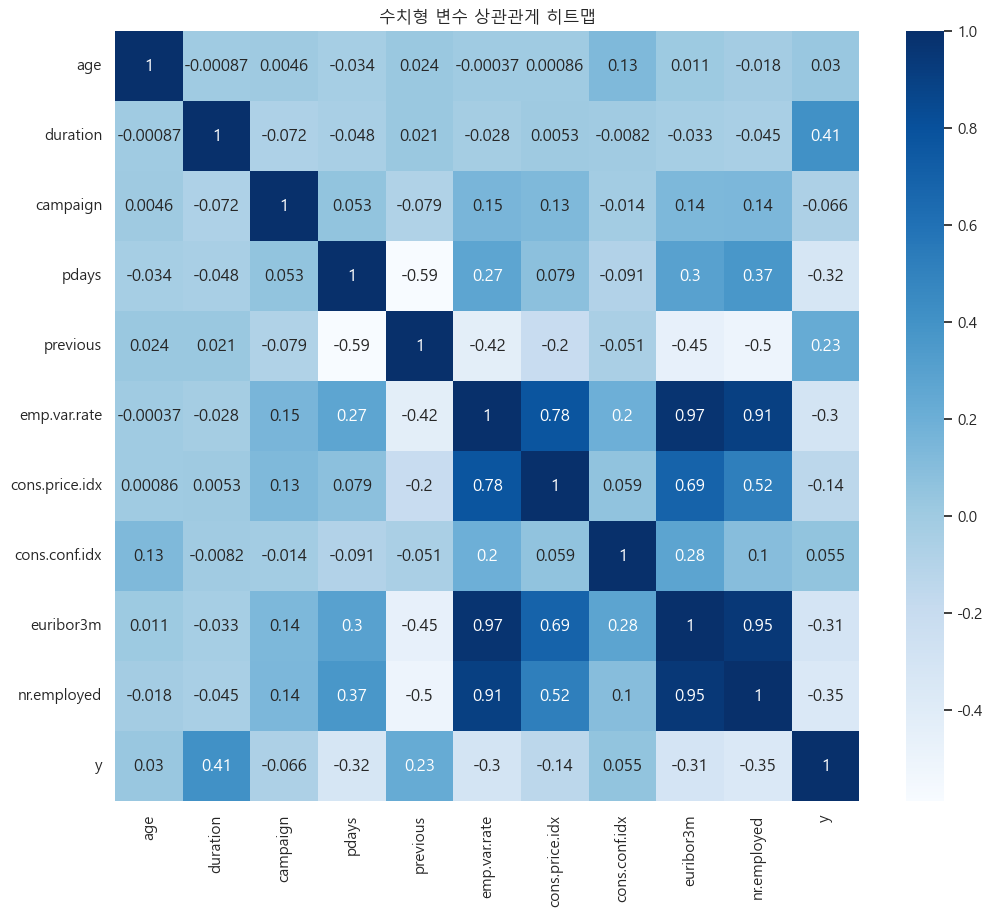

In [ ]:
# 상관관계 분석
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr.corr(), annot=True, cmap='Blues')
plt.title("수치형 변수 상관관게 히트맵")
plt.show()

### 2) 수치형변수 상관관계 시각화 결과
#### 정기예금 가입 여부와 상관관계가 높은 수치형 변수 리스트
1. duration : 0.41(양의 상관관계)
1. re.employed : -0.35(음의 상관관계)
1. pdays : -0.32(음의 상관관계)
1. euribor3m : -0.31(음의 상관관계)
1. emp.var.rate : -0.3(음의 상관관계)

## 2-6. 가입 여부에 따른 수치형 데이터 평균값 비교
### 1) 정기예금 가입 여부에 따른 평균값 산출

In [ ]:
# 정기예금 가입여부에 따른 수치형 데이터 평균값 비교
df_corr.set_index('y').groupby('y').mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


### 2) 가입여부별 수치형 데이터 평균값 비교 결과
- age : 나이와 큰 차이가 없다.
- duration : 예금을 가입한 사람들은 평균 통화 지속시간이 길다.
- campaign : 캠페인을 진행하면서 연락한 횟수는 큰 차이가 없으나, 가입하지 않은 사람들의 평균 전화 횟수가 0.6회정도 더 많다.
- pdays : 예금을 가입한 고객들의 최근 연락날짜는 예금을 가입하지 않은 고객보다 기간이 짧다.
- previous : 예금을 가입한 고객들의 평균적으로 이전 캠페인동안 연락한 횟수가 높다
- emp.var.rate : 예금을 가입한 당시의 고객들의 평균 고용 변동률이 낮다.
- cons.price.idx : 소비자 물가지수는 큰 차이가 없다.
- cons.conf.idx : 소비자 신뢰지수는 큰 차이가 없다.
- euribor3m : 예금을 가입한 고객들의 당시 3개월 유리보 금리는 평균적으로 예금을 가입하지 않은 고객보다 낮다.
- nr.employed : 예금을 가입한 고객들의 당시 고용자 수는 평균적으로 예금을 가입하지 않은 고객보다 낮다.

# 3. 데이터 전처리

## 3-1. 범주형 데이터 인코딩
### 1) 원-핫 인코딩 진행
pandas에서 제공해주는 get_dummies 기능을 사용해서 범주형 데이터를 피쳐 인코딩 진행

In [ ]:
# 범주형 컬럼 리스트
cat_col = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome']

# 범주형 컬럼만 원-핫 인코딩 진행
df_ohe_encoded = pd.get_dummies(df, columns=cat_col, drop_first=True)

# 원-핫 인코딩 완료된 데이터 확인
df_ohe_encoded.sample(5)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
28654,37,284,1,999,1,-1.8,93.075,-47.1,1.410,5099.1,...,0,0,0,0,0,1,0,0,0,0
25399,34,110,1,999,0,-0.1,93.200,-42.0,4.153,5195.8,...,0,1,0,0,0,0,1,0,1,0
12026,58,565,3,999,0,1.4,94.465,-41.8,4.955,5228.1,...,0,0,0,0,0,1,0,0,1,0
33117,34,14,5,999,1,-1.8,92.893,-46.2,1.291,5099.1,...,1,0,0,0,0,0,1,0,0,0
17037,37,130,2,999,0,1.4,93.918,-42.7,4.962,5228.1,...,0,0,0,0,0,0,0,0,1,0


## 3-2. 수치형 데이터 스케일링
### 1) 표준화 진행
연속형 데이터들의 범위를 균등하게 정렬하기 위해 Scikit Learn 에서 제공하는 StandardScaler 기능을 통해 표준화 진행

In [ ]:
from sklearn.preprocessing import StandardScaler

# 표준화 함수 정의
scaler = StandardScaler()

# 표준화 진행할 컬럼 리스트 num_col
df_ohe_encoded[num_col] = scaler.fit_transform(df_ohe_encoded[num_col])

# 표준화 처리된 데이터프레임 별도 저장
df_scaled = df_ohe_encoded.copy()

df_scaled.sample(5)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
19699,0.477486,1.985200,0.878132,0.195414,-0.349494,0.839061,-0.227465,0.951267,0.776458,0.845170,...,0,0,0,0,0,1,0,0,1,0
40810,-0.961898,0.565864,-0.565922,0.195414,5.712397,-0.752343,1.076883,0.648770,-1.581670,-2.815697,...,0,0,0,1,0,1,0,0,0,0
21094,-0.769980,-0.703054,-0.204909,0.195414,-0.349494,0.839061,-0.227465,0.951267,0.774152,0.845170,...,0,0,0,0,0,1,0,0,1,0
24998,-0.482104,-0.861186,-0.565922,0.195414,-0.349494,-0.115781,-0.649003,-0.323542,0.306562,0.398115,...,0,1,0,0,0,0,1,0,1,0
9700,0.573445,-0.625916,1.239145,0.195414,-0.349494,0.839061,1.536429,-0.280328,0.772422,0.845170,...,0,0,0,0,1,0,0,0,1,0


## 3-3. y값 맵핑(0, 1)
### 1) 1, 0 으로 변환
현재 yes, no 으로 표현되는 y 값을 0과 1로 표현하기 위해 map 함수를 사용하여 변환한다.

In [ ]:
# 정기예금 가입 no => 0 , yes => 1
df_scaled['y'] = df_scaled['y'].map({'no' : 0, 'yes' : 1})

df_scaled[['y']].sample(5)

,y
24274,0
32613,0
21350,0
1062,0
29932,0


## 3-4. 훈련, 테스트 데이터셋 분리
### 1) y값 별도로 저장하기
훈련, 테스트 데이터로 분할하기 위해 y값을 먼저 별도로 저장하고, X는 y값을 삭제한다.

In [ ]:
X = df_scaled.drop(columns='y')
y = df_scaled[['y']]

### 2) 데이터 나누기
분류모델로 훈련을 진행하기 위해 전체 데이터셋을 7:3 비율로 나눠 훈련, 테스트셋을 생성

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# 훈련 데이터 크기
print(f"훈련 데이터 크기 : {X_train.shape}")

# 테스트 데이터 크기
print(f"테스트 데이터 크기 : {X_test.shape}")

훈련 데이터 크기 : (28831, 53)
테스트 데이터 크기 : (12357, 53)


# 4. 분류 모델 생성하기
## 4-1. 분류 모델 소개
### 1) 선형 모델 종류
- 로지스틱 회귀분석 : 명칭은 회귀분석이지만, 분류를 진행할 때 사용되는 모델로 사용된다. 선형데이터에 적용이 가능한 모델로, 해당 데이터셋에는 적용이 어려움
### 2) 비선형 모델 종류
- 의사결정나무 : 트리 구조를 기반으로 의사결정을 수행하는 모델
    - Decision Tree
- 랜덤 포레스트 분류분석 : 여러 개의 의사결정나무를 결합하여 성능을 향상한 모델
    - RandomForest Classification
- 그래디언트 부스팅 : 여러 개의 약한 학습기를 결합하여 강한 분류기를 만드는 모델
    - XGBoost, LightGBM, CatBoost

## 4-2. 모델 선택
### 1) 의사결정나무
분류의 기본이 되는 의사결정나무를 사용해서 데이터를 분류하고, 분류를 얼만큼 정확하게 진행하였는지 점수를 확인

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# 결정트리 분류 모델 생성
dt_model = DecisionTreeClassifier(random_state=42)

# 결정트리 모델 훈련
dt_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측값 생성
dt_preds = dt_model.predict(X_test)

# 모델 정확도 확인
dt_score = dt_model.score(X_test, y_test)

print(f"결정트리 분류 점수 : {dt_score:.4f}점")

결정트리 분류 점수 : 0.8899점


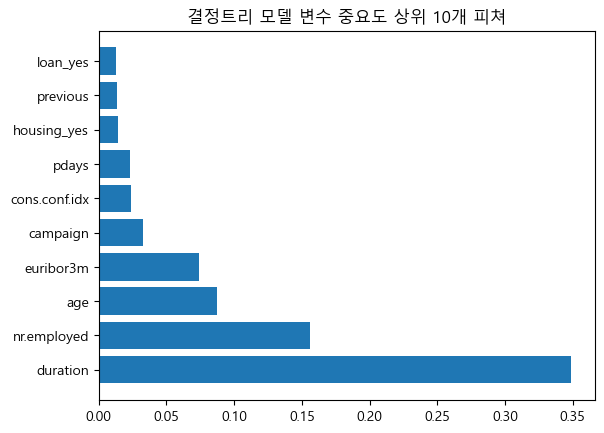

In [ ]:
# 변수 중요도 데이터 프레임화
dt_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_model.feature_importances_
})

# 변수 중요도 상위 10개
dt_top10_importances = dt_importances.sort_values('importance', ascending=False).head(10)

# 변수 중요도 결과 시각화
plt.barh(width=dt_top10_importances['importance'], y=dt_top10_importances['feature'])
plt.title("결정트리 모델 변수 중요도 상위 10개 피쳐")
plt.show()

### 2) 랜덤포레스트 분류
여러 의사결정나무들이 앙상블된 랜덤포레스트 분류분석을 진행하고, 얼만큼 잘 분류되었는지 점수를 확인

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류 모델 생성
rf_model = RandomForestClassifier(random_state=42)

# 랜덤포레스트 모델 훈련
rf_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측값 생성
rf_preds = rf_model.predict(X_test)

# 랜덤포레스트 분류 모델 정확도 확인
rf_score = rf_model.score(X_test, y_test)

print(f"랜덤포레스트 분류 점수 : {rf_score:.4f}점")

랜덤포레스트 분류 점수 : 0.9149점


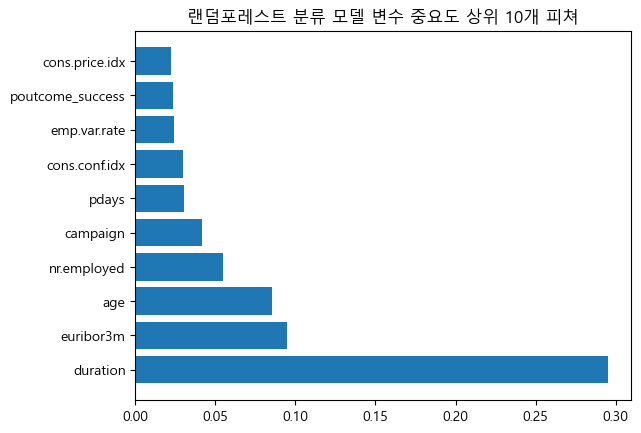

In [ ]:
# 변수 중요도 데이터 프레임화
rf_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})

# 변수 중요도 상위 10개
rf_top10_importances = rf_importances.sort_values('importance', ascending=False).head(10)

# 변수 중요도 결과 시각화
plt.barh(width=rf_top10_importances['importance'], y=rf_top10_importances['feature'])
plt.title("랜덤포레스트 분류 모델 변수 중요도 상위 10개 피쳐")
plt.show()

### 3) 분류모델 점수 및 변수 중요도 결과
#### 의사결정나무
- 약 89점의 분류 정확도 보유
- duration, nr.employed, age, euribor3m 순서로 변수 중요도가 높음

#### 랜덤포레스트 분류
- 약 91점의 분류 정확도 보유
- duration, euribor3m, age, nr.employed 순서로 변수 중요도가 높음

### 4) 혼동행렬 구하기

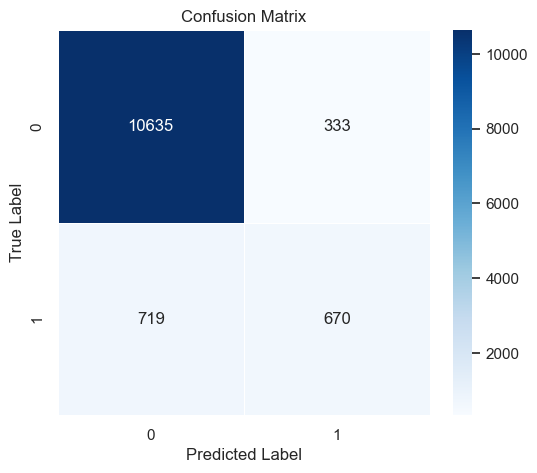

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 혼동 행렬 생성
cm = confusion_matrix(y_test, rf_preds)

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5)

# 그래프 설정
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 정확도 (Accuracy)
accuracy = accuracy_score(y_test, rf_preds)

# 정밀도 (Precision)
precision = precision_score(y_test, rf_preds, average='weighted')  # 'weighted'는 클래스 불균형 고려

# 재현율 (Recall)
recall = recall_score(y_test, rf_preds, average='weighted')

# F1-score
f1 = f1_score(y_test, rf_preds, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Accuracy: 0.9149
Precision: 0.9065
Recall: 0.9149
F1-score: 0.9087


In [ ]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10968
           1       0.67      0.48      0.56      1389

    accuracy                           0.91     12357
   macro avg       0.80      0.73      0.76     12357
weighted avg       0.91      0.91      0.91     12357



### 혼동행렬 분석
- precision(정밀도) : 예측값이 True인 데이터 중에서 실제값이 True 인 데이터
    - 0 : 예금을 가입하지 않을 사람을 약 94% 잘 분류하였다.
    - 1 : 예금에 가입한 사람을 약 67% 잘 분류하였다.
- recall(재현율) : 실제 데이터 중에서 모델이 정확하게 예측한 비율
    - 0 : 재현율 0.97로 예금을 가입하지 않을 대부분의 사람을 맞췄다.
    - 1 : 재현율 0.48로 예금에 가입할 사람을 잘 분류하지 못했다.
- F1-Score(F1스코어) : 정밀도와 재현율의 조화 평균
    - 0 : F1score 0.91으로 예금을 가입하지 않을 사람을 분류하는데 우수하다.
    - 1 : F1score 0.56으로 예금에 가입할 사람을 분류하는데 우수하지 못하다.
- Accuracy(정확도) : 정확도는 0.91으로 전체 데이터 중에서 약 91%의 데이터를 맞췄다.

In [ ]:
rf_top10_importances

,feature,importance
1,duration,0.295058
8,euribor3m,0.094876
0,age,0.085516
9,nr.employed,0.054814
2,campaign,0.041603
3,pdays,0.030177
7,cons.conf.idx,0.029846
5,emp.var.rate,0.024137
52,poutcome_success,0.023622
6,cons.price.idx,0.022525


# 5. 결론
## 5-1. 마케팅 제안
### 변수 중요도에 따른 예금 가입률 인상 방안
#### 8-1. 고객 상담 전략 강화 (duration)

마지막 통화 지속 시간이 모델에서 가장 중요한 피쳐로 나타남 → 고객과의 상담 시간이 증가할수록 고객이 정기 예금에 가입할 확률이 높음

📌 마케팅 전략 :

- 영업 상담원이 고객과 충분한 시간을 갖고 설명할 수 있도록 **대화 스크립트 및 상담 기술 강화**
- 기존 가입 고객의 주요 관심사를 분석하여 **맞춤형 상담 내용 제공**
- 상담 중 특정 반응(예: 관심 표시, 질문 빈도)이 있는 고객을 타겟으로 추가 컨텍을 진행

### 8-2. 금리 혜택 홍보 (euribor3m)

3개월 유리보 금리가 낮을 때 정기 예금에 가입할 확률이 높음

📌 마케팅 전략 :

- 금리 변동 실시간 모니터링을 통해 금리가 낮은 시점에 예금 가입 홍보 캠페인을 적극적으로 진행
- 낮은 금리와 관련된 홍보문구를 활용하여 고객의 관심도를 가져옴

### 8-3. 연령별 맞춤 마케팅 (age)

특정 연령대별로 맞춤 혜택을 제공

📌 마케팅 전략 :

- 청년층(20~30대) : 단기 고금리 상품, 월급 계좌를 자사 은행으로 옮길 경우 예금 이자 혜택 제공
- 중장년층(40대~60대) : 안정적인 장기 예금 상품 마련, 노후 대비 은퇴자금을 마련할 수 있도록 금융 컨설팅 제공 및 예금 상품 추천

### 8-4. 경제 지표 (nr.emplyed, emp.var.rate, cons.price.idx, cons.conf.idx)

사회 경제 지표와 관련된 변수들은 직접 통제할 수 없는 변수들로 시기에 따라서 유동적인 마케팅 방법을 적용하여 고객의 예금 가입 전환을 위한 전략을 수립

📌 마케팅 전략 :

- 경제 불안정 시기 : 고객들에게 불안한 경제 상황을 설명함과 동시에 안전한 투자 상품인 저금리 예금 상품을 추천
- 경제 성장기 : 손실 위험이 크지만 이자가 높은(하이리스크 하이리턴) 상품을 적극 추천하여 경제 성장기에 맞춰 높은 이자를 받아갈 수 있도록 홍보함

### 8-5. 캠페인 전략 (campaign, pdays, poutcome_success)

이전 캠페인 결과를 바탕으로 예금을 가입한 고객들과 가입하지 않은 고객을 비교

📌 마케팅 전략 :

- 너무 잦은 연락을 지양 : 예금 가입 권유 전화를 자주 할 수록 고객의 관심도는 낮아질 수 있음
- pdays가 999일로 분류된 고객들에게 주로 연락을 진행